In [37]:
from hvacmeter import *
from sparqlwrapper_brick import BrickEndpoint
import matplotlib.pyplot as plt
import pandas as pd                                                             
import numpy as np
import statsmodels.api as sm

In [38]:
# Init Brick interface and the learner
brick_endpoint = BrickEndpoint('http://132.239.10.197:8890/sparql', '1.0.2')
hvacmeter = HvacMeter('ebu3b', brick_endpoint)

C:\Users\bk\Anaconda3\lib\site-packages\SPARQLWrapper\Wrapper.py:585: RuntimeWarning: Sending Accept header '*/*' because unexpected returned format 'json' in a 'LOAD' SPARQL query form
  warnings.warn("Sending Accept header '*/*' because unexpected returned format '%s' in a '%s' SPARQL query form" % (self.returnFormat, self.queryType), RuntimeWarning)


In [12]:
# Read water meters
points = hvacmeter.get_chilled_water_sensors()
print(points)
cwrt = hvacmeter.get_point_data(points['?cwrt'])
cwst = hvacmeter.get_point_data(points['?cwst'])
cwf = hvacmeter.get_point_data(points['?cwf'])
hvacmeter.df['water_thermal_power'] = cwf.multiply(cwrt - cwst)
hvacmeter.df.head()

{'?cwf': 'http://ucsd.edu/building/ontology/ebu3b#EBU3B_Chilled_Water_Flow_Sensor', '?cwst': 'http://ucsd.edu/building/ontology/ebu3b#EBU3B_Chilled_Water_Supply_Temperature_Sensor', '?cwrt': 'http://ucsd.edu/building/ontology/ebu3b#EBU3B_Chilled_Water_Return_Temperature_Sensor'}


,Q_ahu_cooling_power,Q_vav_cooling_power,Q_ahu_returned_power,water_thermal_power,C3
2018-04-06 00:00:00+00:00,None,None,None,864.348382,1
2018-04-06 00:05:00+00:00,None,None,None,777.715859,1
2018-04-06 00:10:00+00:00,None,None,None,755.051901,1
2018-04-06 00:15:00+00:00,None,None,None,761.283726,1
2018-04-06 00:20:00+00:00,None,None,None,824.022524,1


In [18]:
# Caculate AHU returned thermal data.
ahus = hvacmeter.get_ahus()
ahu = ahus[0]
daf = hvacmeter.get_ahu_disch_airflow(ahu)
ahu_points = hvacmeter.get_ahu_points(ahu)
rat = hvacmeter.get_point_data(ahu_points['?rat'])
mat = hvacmeter.get_point_data(ahu_points['?mat'])
power = daf.multiply(rat - mat)
hvacmeter.df['Q_ahu_returned_power'] = power

In [20]:
hvacmeter.df.head()

,Q_ahu_cooling_power,Q_vav_cooling_power,Q_ahu_returned_power,water_thermal_power,C3
2018-04-06 00:00:00+00:00,None,None,23104.509364,864.348382,1
2018-04-06 00:05:00+00:00,None,None,23784.430274,777.715859,1
2018-04-06 00:10:00+00:00,None,None,24082.937156,755.051901,1
2018-04-06 00:15:00+00:00,None,None,24141.604884,761.283726,1
2018-04-06 00:20:00+00:00,None,None,23320.601457,824.022524,1


In [25]:
# Caculate power per VAV.
point_sets = hvacmeter.get_vavs_points(ahu)
powers = [hvacmeter.calc_vav_cooling_power(points) for points in list(point_sets.values())[0:hvacmeter.max_vav_num]]

In [26]:
#Sum up the VAV powers
none_cnt = sum([not isinstance(power, pd.Series) for power in powers])
powers_sum = sum([power for power in powers if isinstance(power, pd.Series)]) * len(powers) / (len(powers) - none_cnt)
hvacmeter.df['Q_vav_cooling_power'] = powers_sum

In [27]:
hvacmeter.df.head()

,Q_ahu_cooling_power,Q_vav_cooling_power,Q_ahu_returned_power,water_thermal_power,C3
2018-04-06 00:00:00+00:00,None,15959.835549,23104.509364,864.348382,1
2018-04-06 00:05:00+00:00,None,16431.331521,23784.430274,777.715859,1
2018-04-06 00:10:00+00:00,None,18047.347960,24082.937156,755.051901,1
2018-04-06 00:15:00+00:00,None,17783.189148,24141.604884,761.283726,1
2018-04-06 00:20:00+00:00,None,17752.485120,23320.601457,824.022524,1


In [30]:
x = hvacmeter.df[['Q_vav_cooling_power', 'Q_ahu_returned_power', 'C3']]
y = hvacmeter.df['water_thermal_power']
hvacmeter.model = sm.OLS(y, x).fit()

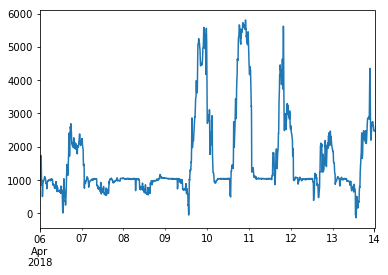

In [32]:
pred = hvacmeter.model.predict(hvacmeter.df[['Q_vav_cooling_power', 'Q_ahu_returned_power', 'C3']])

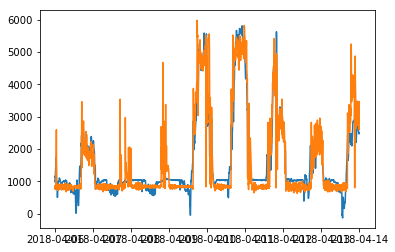

In [36]:
plt.plot(pred)
plt.plot(hvacmeter.df['water_thermal_power'], li)
plt.show()